# 임베딩레이어와 tanh로 network 만들기
- RNN은 이전 결과 혹은 이전 데이터를 사용하여 미래의 값을 예측하는 신경망이지만 이번에 다룰 임베딩 레이어와 선형변환층을 사용한 network는 과거의 데이터는 사용하지 않기 때문에 RNN이라고는 할 수 없음
- RNN과 network의 구조를 비슷하게 만들어 RNN의 필요성과 구조를 눈에 익히기 위해 만듬

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

## 준비

In [2]:
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

`-` tanh activation function
- tanh는 -1부터 1사이의 값을 출력하는 활성화 함수

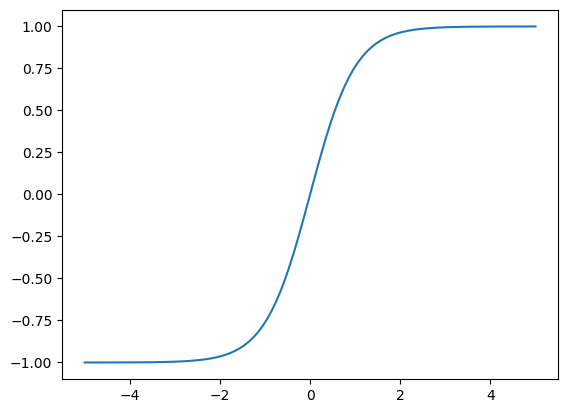

In [3]:
_x = torch.linspace(-5,5,100)
plt.plot(_x,tanh(_x))

`-` 문자를 mapping을 통해 숫자로 변환
- 딥러닝을 돌리기 위해서는 input이 문자가 아닌 숫자여야 함
- mapping은 key와 value로 구성된 딕셔너리가 들어감
- txt는 키값이 되어 value인 숫자가 출력됨

In [4]:
def f(txt, mapping):
    return [mapping[key] for key in txt]

In [5]:
txt = ['a', 'b', 'c']
mapping = {'a':0, 'b':1, 'c':2}
f(txt,mapping)

[0, 1, 2]

In [6]:
txt = list('ab')*100
txt_x = txt[:-1]
txt_y = txt[1:]

In [7]:
txt_x[:5],txt_y[:5]

(['a', 'b', 'a', 'b', 'a'], ['b', 'a', 'b', 'a', 'b'])

`- `class를 사용해 network를 만드는 방법
- def __init__에서는 사용할 변수(레이어)를 선언
- def forward()에서는 __init__에서 선언한 변수(레이어)를 어떻게 연산하여 yhat을 정의할지를 코드로 구현한 후 yhat을 return

```python
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat
```

## 원핫 인코딩

### type 1)
- mapping 단계에서 원핫 인코딩을 진행

In [8]:
txt = list('ab')*100
mapping = {'a':[1, 0], 'b':[0, 1]}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,2).to('cuda:0')
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,2).to('cuda:0')
x[:5], y[:5]

(tensor([[1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.]], device='cuda:0'),
 tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]], device='cuda:0'))

In [9]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=2,bias=False)
).to('cuda:0')

loss_fn = torch.nn.CrossEntropyLoss()

optimizr = torch.optim.Adam(net.parameters())

In [10]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

- 값이 크면 노란색, 값이 작으면 보라색으로 출력됨 

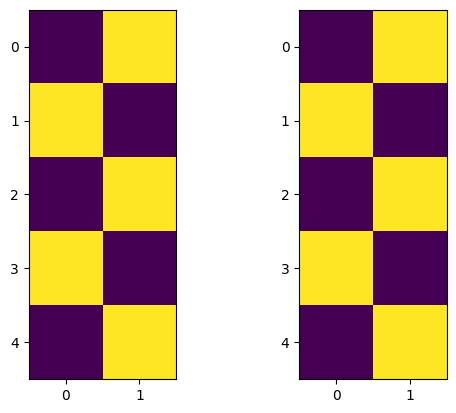

In [11]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y[:5].to('cpu'))
ax[1].imshow(soft(net(x[:5]).to('cpu')).data)

### type 2)
- torch.nn.Embedding()을 사용하면 자동으로 원핫 인코딩을 한 후 선형변환을 함

In [12]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(list('abc')*100,mapping)).to('cuda:0')
y = torch.tensor(f(list('bca')*100,mapping)).to('cuda:0')
x[:5],y[:5]

(tensor([0, 1, 2, 0, 1], device='cuda:0'),
 tensor([1, 2, 0, 1, 2], device='cuda:0'))

In [13]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(num_embeddings=3,embedding_dim=1).to('cuda:0')
ebdd(x)[:5]

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052]], device='cuda:0', grad_fn=<SliceBackward0>)

In [14]:
ebdd.weight

Parameter containing:
tensor([[-0.8178],
        [-0.7052],
        [-0.5843]], device='cuda:0', requires_grad=True)

- embedding layer는 a, b, c에 적용할 weight가 각각 있어서 weight가 3개임

In [15]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).to('cuda:0')
y = torch.tensor(f(txt_y,mapping)).to('cuda:0')
x[:5], y[:5]

(tensor([0, 1, 0, 1, 0], device='cuda:0'),
 tensor([1, 0, 1, 0, 1], device='cuda:0'))

- embedding layer에서 원핫인코딩이 실행되어야 하므로 실수형이 아닌 정수형으로 데이터를 입력해줌

In [16]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=2,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=2)
).to('cuda:0')

loss_fn = torch.nn.CrossEntropyLoss()

optimizr = torch.optim.Adam(net.parameters())

In [17]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

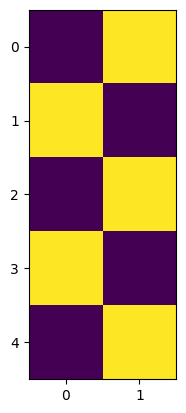

In [18]:
plt.imshow(soft(net(x[:5]).to('cpu')).data)

### 임베딩 레이어를 사용해 abcde 예측하기

In [19]:
txt = list('abcde')*100
mapping = {'a':0,'b':1,'c':2,'d':3,'e':4}

txt_x = txt[:-1]
txt_y = txt[1:]

x = torch.tensor(f(txt_x, mapping)).to('cuda:0')
y = torch.tensor(f(txt_y, mapping)).to('cuda:0')

- 1개의 은닉노드는 2개의 문자를 표현, 2개의 은닉노드는 4개의 문자를 표현  
`->` $2^n$으로 문자를 표현할 수 있음
- 5개의 문자열이므로 $n = 3$이 적합함

In [20]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=5, embedding_dim = 3),
    torch.nn.Tanh(),
    torch.nn.Linear(3, 5)
).to('cuda:0')

loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(net.parameters())

In [21]:
for epoch in range(5000):
    #
    yhat = net(x)
    #
    loss = loss_fn(yhat, y)
    #
    loss.backward()
    #
    optim.step()
    optim.zero_grad()

In [22]:
net[-1]

Linear(in_features=3, out_features=5, bias=True)

Text(0.5, 1.0, 'Vis2: $[h | net(x) | \\hat{y}]$')

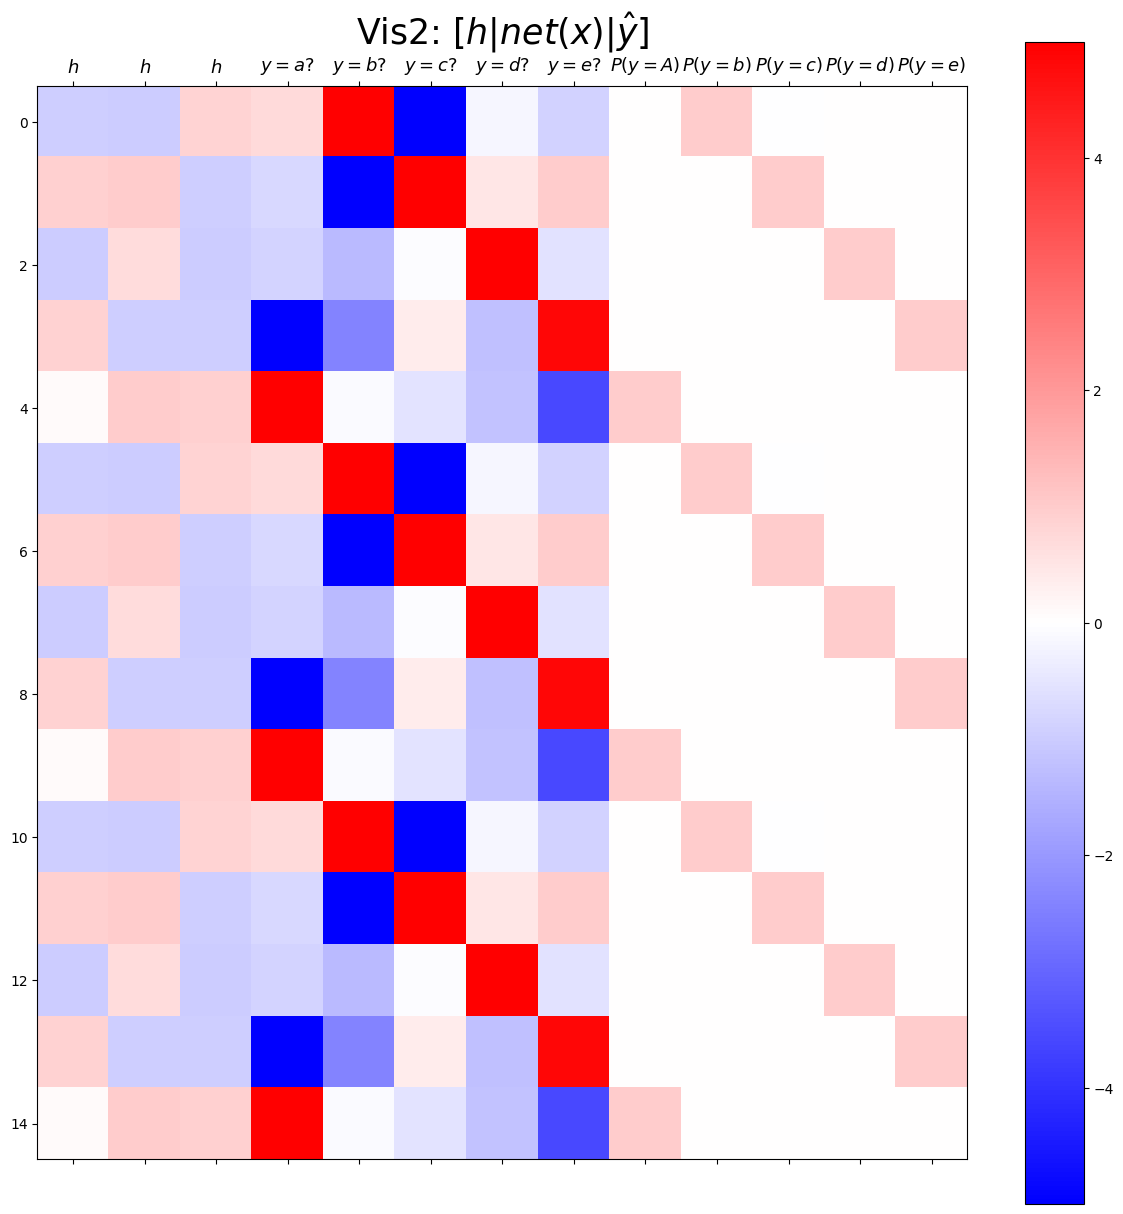

In [23]:
hidden = net[:-1](x).to('cpu').data
yhat = soft(net(x)).to('cpu').data

combined  = torch.concat([hidden, net(x).to('cpu').data, yhat],axis=1)


plt.matshow(combined[:15],vmin=-5,vmax=5,cmap='bwr')
plt.xticks(range(13), labels=[r'$h$',r'$h$',r'$h$',
                              r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$y=e?$',
                              r'$P(y=A)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$',r'$P(y=e)$'],size=13)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

## 한계: AbAcAd

- 위와 같은 문제는 직전 하나의 문자만 보는 것이 아닌 2개의 문자를 보아야 예측을 할 수 있음
- 평범한 임베딩 레이어(선형 변환 레이어)를 사용하면 이와 같은 문제를 해결할 수 없음

In [34]:
txt = list('AbAcAd')*100
mapping = {'A':0, 'b':1,'c':2, 'd':3}

In [35]:
x = torch.tensor(f(txt[:-1],mapping))
y = torch.tensor(f(txt[1:],mapping))

In [36]:
x = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [39]:
x = x.cuda()
y = y.cuda()

In [25]:
class Hnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(in_features=4,out_features=2)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        hidden = self.tanh(self.i2h(x))
        return hidden

In [44]:
torch.manual_seed(43052)

hnet = Hnet().cuda()
linr = torch.nn.Linear(in_features=2,out_features=4).cuda()

loss_fn = torch.nn.CrossEntropyLoss() 

optim = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()))

In [45]:
T = len(x) 
for epoc in range(20): 
    ## 1~2
    loss = 0 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = hnet(xt) 
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optim.step()
    optim.zero_grad()

In [62]:
linr(hnet(x))

tensor([[-0.3589,  0.7921, -0.1970, -0.0302],
        [-0.2912,  0.8140, -0.2032,  0.0178],
        [-0.3589,  0.7921, -0.1970, -0.0302],
        ...,
        [-0.3589,  0.7921, -0.1970, -0.0302],
        [-0.1065,  0.6307, -0.0874,  0.1821],
        [-0.3589,  0.7921, -0.1970, -0.0302]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

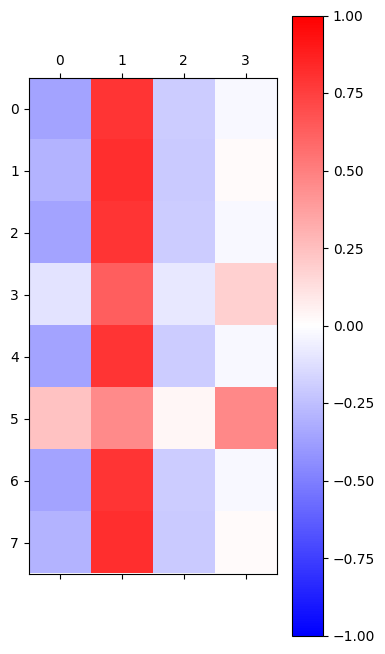

In [60]:
plt.matshow(linr(hnet(x)).cpu().data[:8],vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()